# Neural Cleanse 实现代码【pytorch】

In [1]:
#!git clone https://github.com/tonggege001/MyNeuralCleanse.git

In [2]:
import os
os.chdir("./NeuralCleanse_Torch")

import torch
import numpy as np
from torch.nn import CrossEntropyLoss
import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from data import get_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2024-10-14 15:38:28.210593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 15:38:28.220496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 15:38:28.233396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 15:38:28.237095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 15:38:28.246706: I tensorflow/core/platform/cpu_feature_guar

## 模型逆向
对每个标签依次优化mask，使得训练集图片加上mask之后能分到该标签

In [3]:

def train(model, target_label, train_loader, param):
    """对某一target_label的逆向trigger过程"""

    print("\nProcessing label: {}".format(target_label))

    # 设置初始的随机trigger，以及mask
    width, height = param["image_size"]
    trigger = torch.rand((3, width, height), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((width, height), requires_grad=True)  
    mask = mask.to(device).detach().requires_grad_(True)

    # 优化器的优化参数为trigger以及mask
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    criterion = CrossEntropyLoss()
    model.to(device)
    model.eval()

    # 训练参数
    Epochs = param["Epochs"]
    lamda = param["lamda"]

    # 记录mask的norm值，初始值为无穷大
    min_norm = np.inf 
    min_norm_count = 0

    # 遍历训练集数据，训练Epochs轮
    for epoch in range(Epochs):
        norm = 0.0
        for images, _ in tqdm.tqdm(train_loader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            images = images.to(device)

            # 把trigger和mask添加到图片上
            trojan_images = (1 - torch.unsqueeze(mask, dim=0)) * images + torch.unsqueeze(mask, dim=0) * trigger
            
            # 一般训练过程
            y_pred = model(trojan_images)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            loss = criterion(y_pred, y_target) + lamda * torch.sum(torch.abs(mask))
            loss.backward()
            optimizer.step()

            # 计算mask的norm
            with torch.no_grad():
                # 防止trigger和norm越界
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))
        print("norm: {}".format(norm))

        # early stop
        if norm < min_norm:
            min_norm = norm
            min_norm_count = 0
        else:
            min_norm_count += 1

        if min_norm_count > 5:
            break

    return trigger.cpu(), mask.cpu()



def reverse_engineer():
    param = {
        "dataset": "cifar10",
        "Epochs": 20,  # 每个类别进行trigger逆向训练的轮数
        "batch_size": 64,
        "lamda": 0.01,
        "num_classes": 10,
        "image_size": (32, 32)
    }

    # 加载模型和数据集
    model = torch.load('model_cifar10.pkl', weights_only=False).to(device)
    _, _, x_test, y_test = get_data(param)
    x_test, y_test = torch.from_numpy(x_test)/255., torch.from_numpy(y_test)
    train_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=param["batch_size"], shuffle=False)
    
    # 开始逆向，依次遍历每个标签 
    norm_list = []
    for label in range(param["num_classes"]):
        # 对每个标签，逆向对应的trigger和mask
        trigger, mask = train(model, label, train_loader, param)
        norm_list.append(mask.sum().item())

        # 将逆向出的trigger和mask图像保存
        trigger = trigger.cpu().detach().numpy()
        trigger = np.transpose(trigger, (1,2,0))
        plt.axis("off")
        plt.imshow(trigger)
        plt.savefig('mask/trigger_{}.png'.format(label), bbox_inches='tight', pad_inches=0.0)

        mask = mask.cpu().detach().numpy()
        plt.axis("off")
        plt.imshow(mask)
        plt.savefig('mask/mask_{}.png'.format(label), bbox_inches='tight', pad_inches=0.0)

    print(norm_list)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 120s 1us/step

Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 168.11it/s]


norm: 344.9391174316406


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 200.17it/s]


norm: 171.0764617919922


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 186.01it/s]


norm: 94.22945404052734


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 221.20it/s]


norm: 66.65824127197266


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 209.20it/s]


norm: 53.65497970581055


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 221.22it/s]


norm: 46.42060852050781


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 188.56it/s]


norm: 43.38617706298828


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 204.55it/s]


norm: 41.814205169677734


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 223.67it/s]


norm: 40.15926742553711


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 196.24it/s]


norm: 39.19778060913086


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 209.14it/s]


norm: 38.958518981933594


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 214.09it/s]


norm: 38.68577194213867


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 162.60it/s]


norm: 38.20472717285156


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 191.94it/s]


norm: 37.95341491699219


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 166.97it/s]


norm: 37.737213134765625


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 221.16it/s]


norm: 37.44322967529297


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 203.33it/s]


norm: 37.26314926147461


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 196.47it/s]


norm: 37.10655212402344


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 204.32it/s]


norm: 37.05293655395508


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 219.92it/s]


norm: 37.03380584716797

Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 185.58it/s]


norm: 341.26251220703125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 236.49it/s]


norm: 180.2685089111328


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 217.07it/s]


norm: 103.35936737060547


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 203.50it/s]


norm: 69.92677307128906


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 221.79it/s]


norm: 53.455955505371094


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 175.31it/s]


norm: 45.75458526611328


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 226.40it/s]


norm: 41.539710998535156


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 189.41it/s]


norm: 39.414825439453125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 238.40it/s]


norm: 38.3152961730957


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 227.47it/s]


norm: 37.232173919677734


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 220.05it/s]


norm: 36.76554870605469


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 218.19it/s]


norm: 36.1920280456543


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 186.00it/s]


norm: 35.336524963378906


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 154.55it/s]


norm: 34.79604721069336


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 177.21it/s]


norm: 34.365394592285156


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 223.95it/s]


norm: 34.145565032958984


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 201.96it/s]


norm: 33.94086837768555


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 212.81it/s]


norm: 33.795875549316406


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 229.21it/s]


norm: 33.725364685058594


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 235.56it/s]


norm: 33.53691864013672

Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 206.44it/s]


norm: 266.6080322265625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 229.86it/s]


norm: 123.30653381347656


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 192.90it/s]


norm: 68.47433471679688


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 197.38it/s]


norm: 52.25978088378906


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 206.88it/s]


norm: 48.10923767089844


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 233.03it/s]


norm: 45.82350158691406


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 238.19it/s]


norm: 44.594852447509766


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 218.49it/s]


norm: 43.65962219238281


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 237.37it/s]


norm: 42.902381896972656


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 211.74it/s]


norm: 42.55080032348633


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 173.51it/s]


norm: 41.943538665771484


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 221.33it/s]


norm: 41.443511962890625


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 194.92it/s]


norm: 41.355438232421875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 229.82it/s]


norm: 41.25821304321289


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 216.50it/s]


norm: 41.219390869140625


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 215.53it/s]


norm: 41.04063415527344


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 231.56it/s]


norm: 40.870086669921875


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 228.45it/s]


norm: 40.7893180847168


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 223.13it/s]


norm: 40.634681701660156


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 165.44it/s]


norm: 40.47748947143555

Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 224.19it/s]


norm: 265.7603759765625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 228.28it/s]


norm: 120.93313598632812


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 209.64it/s]


norm: 73.4814453125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 192.19it/s]


norm: 56.467933654785156


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 216.59it/s]


norm: 50.2197380065918


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 235.89it/s]


norm: 47.39590835571289


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 209.33it/s]


norm: 46.173240661621094


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 231.31it/s]


norm: 45.424163818359375


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 211.25it/s]


norm: 44.65312957763672


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 222.41it/s]


norm: 43.71756362915039


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 221.61it/s]


norm: 43.13690185546875


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 235.83it/s]


norm: 42.79896926879883


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 235.16it/s]


norm: 42.24182891845703


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 235.24it/s]


norm: 41.91376495361328


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 236.09it/s]


norm: 41.71824264526367


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 219.96it/s]


norm: 41.55550003051758


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 211.55it/s]


norm: 41.377159118652344


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 195.31it/s]


norm: 41.241859436035156


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 232.58it/s]


norm: 41.12128448486328


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 224.23it/s]


norm: 41.02935028076172

Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 215.18it/s]


norm: 283.7349548339844


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 186.53it/s]


norm: 127.16685485839844


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 184.49it/s]


norm: 77.85733795166016


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 198.92it/s]


norm: 59.48109436035156


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 227.43it/s]


norm: 51.705936431884766


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 213.06it/s]


norm: 47.31047058105469


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 200.17it/s]


norm: 45.19902420043945


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 219.28it/s]


norm: 43.81742858886719


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 231.45it/s]


norm: 42.897682189941406


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 187.84it/s]


norm: 42.251312255859375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 211.18it/s]


norm: 41.881866455078125


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 185.60it/s]


norm: 41.18312072753906


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 217.20it/s]


norm: 40.5717887878418


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 229.06it/s]


norm: 40.11791229248047


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 230.40it/s]


norm: 39.804588317871094


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 187.05it/s]


norm: 39.55303955078125


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 208.44it/s]


norm: 39.5408935546875


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 225.74it/s]


norm: 39.325660705566406


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 219.85it/s]


norm: 39.17454528808594


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 220.43it/s]


norm: 39.01323699951172

Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 188.35it/s]


norm: 324.1100769042969


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 190.32it/s]


norm: 154.88427734375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 196.39it/s]


norm: 89.28743743896484


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 192.31it/s]


norm: 63.374351501464844


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 206.58it/s]


norm: 51.702247619628906


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 218.46it/s]


norm: 45.90825653076172


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 206.88it/s]


norm: 42.276893615722656


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 233.24it/s]


norm: 39.6661262512207


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 211.45it/s]


norm: 38.249908447265625


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 153.53it/s]


norm: 37.38811492919922


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 183.07it/s]


norm: 36.90288543701172


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 223.28it/s]


norm: 36.42155456542969


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 222.58it/s]


norm: 36.11773681640625


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 213.02it/s]


norm: 35.700008392333984


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 206.27it/s]


norm: 35.08579635620117


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 206.74it/s]


norm: 34.792137145996094


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 224.99it/s]


norm: 34.56732177734375


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 215.22it/s]


norm: 34.401954650878906


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 222.99it/s]


norm: 34.16114044189453


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 221.94it/s]


norm: 33.956390380859375

Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 235.53it/s]


norm: 110.26998901367188


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 233.80it/s]


norm: 58.88046646118164


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 175.19it/s]


norm: 49.82501983642578


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 219.45it/s]


norm: 46.46026611328125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 198.55it/s]


norm: 45.54612731933594


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 232.47it/s]


norm: 44.964595794677734


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 218.00it/s]


norm: 44.59088897705078


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 229.28it/s]


norm: 44.345130920410156


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 197.76it/s]


norm: 43.995277404785156


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 232.44it/s]


norm: 43.76170349121094


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 221.34it/s]


norm: 43.63237380981445


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 204.46it/s]


norm: 43.484825134277344


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 189.45it/s]


norm: 43.49048614501953


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 204.01it/s]


norm: 43.23314666748047


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 225.91it/s]


norm: 42.91050720214844


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 213.21it/s]


norm: 42.548851013183594


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 234.15it/s]


norm: 41.97352981567383


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 218.09it/s]


norm: 41.58082580566406


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 230.38it/s]


norm: 41.33653259277344


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 230.20it/s]


norm: 41.31446838378906

Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 182.24it/s]


norm: 346.2099914550781


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 219.56it/s]


norm: 181.05267333984375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 218.83it/s]


norm: 103.4543685913086


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 211.60it/s]


norm: 71.45997619628906


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 204.44it/s]


norm: 55.769081115722656


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 188.76it/s]


norm: 46.63471603393555


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 225.83it/s]


norm: 41.23798751831055


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 185.14it/s]


norm: 38.972129821777344


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 186.29it/s]


norm: 37.429019927978516


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 163.49it/s]


norm: 36.80267333984375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 193.90it/s]


norm: 36.399574279785156


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 190.48it/s]


norm: 35.67546844482422


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 225.51it/s]


norm: 35.04151153564453


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 178.21it/s]


norm: 34.59589385986328


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 224.49it/s]


norm: 34.20404815673828


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 219.82it/s]


norm: 33.88312530517578


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 223.64it/s]


norm: 33.4590950012207


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 213.48it/s]


norm: 33.242523193359375


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 175.08it/s]


norm: 33.19141387939453


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 169.17it/s]


norm: 33.18946075439453

Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 174.01it/s]


norm: 280.7975158691406


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 184.74it/s]


norm: 109.14376831054688


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 218.67it/s]


norm: 44.61474609375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 212.45it/s]


norm: 22.764041900634766


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 227.08it/s]


norm: 15.128530502319336


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 227.93it/s]


norm: 12.660562515258789


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 221.33it/s]


norm: 11.758047103881836


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 223.78it/s]


norm: 11.372983932495117


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 232.20it/s]


norm: 10.96634292602539


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 233.32it/s]


norm: 10.677316665649414


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 204.44it/s]


norm: 10.504955291748047


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 179.45it/s]


norm: 10.282674789428711


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 204.44it/s]


norm: 10.109087944030762


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 221.99it/s]


norm: 10.059890747070312


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 217.36it/s]


norm: 10.032485961914062


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 179.20it/s]


norm: 9.994447708129883


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 200.19it/s]


norm: 9.971887588500977


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 220.30it/s]


norm: 9.955894470214844


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 233.10it/s]


norm: 9.954587936401367


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 234.46it/s]


norm: 9.94442081451416

Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 233.89it/s]


norm: 265.137939453125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 229.00it/s]


norm: 109.04846954345703


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 195.09it/s]


norm: 62.17549133300781


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 195.85it/s]


norm: 48.20404815673828


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 219.67it/s]


norm: 43.06770324707031


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 216.14it/s]


norm: 40.833587646484375


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 209.49it/s]


norm: 39.023345947265625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 229.92it/s]


norm: 38.01737594604492


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 220.54it/s]


norm: 37.26864242553711


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 182.10it/s]


norm: 36.790977478027344


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 233.68it/s]


norm: 36.51753234863281


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 213.88it/s]


norm: 36.1248893737793


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 218.24it/s]


norm: 35.720523834228516


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 231.24it/s]


norm: 35.453285217285156


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 224.19it/s]


norm: 35.314842224121094


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 231.31it/s]


norm: 35.293212890625


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 224.48it/s]


norm: 35.25005340576172


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 171.41it/s]


norm: 35.22734069824219


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 183.50it/s]


norm: 35.1923828125


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 203.98it/s]


norm: 35.05598449707031
[37.03380584716797, 33.536922454833984, 40.47748565673828, 41.02935791015625, 39.01323699951172, 33.956390380859375, 41.31446838378906, 33.18946075439453, 9.944419860839844, 35.05598449707031]


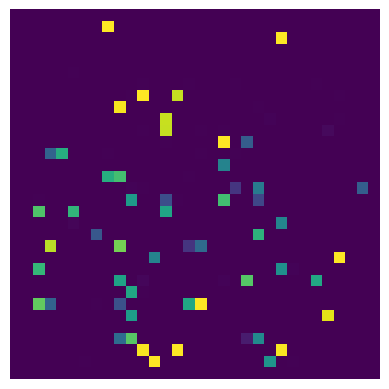

In [4]:
reverse_engineer()

## 显示逆向的trigger

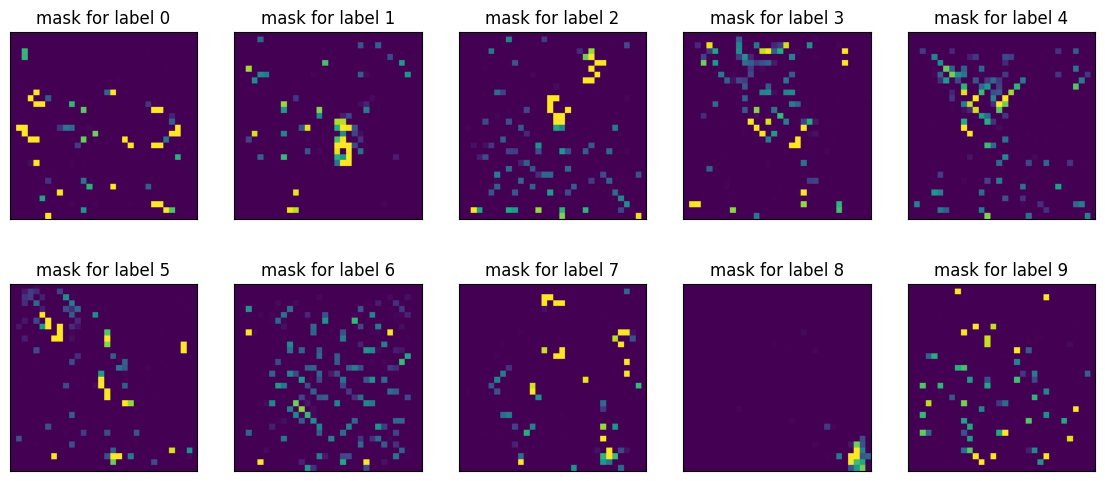

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))
N=2
M=5

#形成NxM大小的画布
for i in range(10):#有10张图片
    path='mask/mask_'+str(i)+'.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0
    plt.title('mask for label '+str(i))
    plt.imshow(img)

    plt.xticks([])
    plt.yticks([])
plt.show()

## 异常值检测方法MAD
找出trigger类别

In [6]:
from tensorflow.keras.utils import load_img,img_to_array

RESULT_DIR = 'mask'  # directory for storing results

# input size
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_COLOR)
NUM_CLASSES = 10  


def outlier_detection(l1_norm_list, idx_mapping):
    """MAD异常值检测"""

    # 计算MAD的median值
    consistency_constant = 1.4826  # if normal distribution
    median = np.median(l1_norm_list)
    mad = consistency_constant * np.median(np.abs(l1_norm_list - median))
    min_mad = np.abs(np.min(l1_norm_list) - median) / mad

    # anomaly index值大于2则认为模型存在后门
    print('median: %f, MAD: %f' % (median, mad))
    print('anomaly index: %f' % min_mad)

    # 找出norm大于2的mask标签
    flag_list = []
    for y_label in idx_mapping:
        if l1_norm_list[idx_mapping[y_label]] > median:
            continue
        if np.abs(l1_norm_list[idx_mapping[y_label]] - median) / mad > 2:
            flag_list.append((y_label, l1_norm_list[idx_mapping[y_label]]))

    if len(flag_list) > 0:
        flag_list = sorted(flag_list, key=lambda x: x[1])

    print('flagged label list: %s' %
          ', '.join(['%d: %2f' % (y_label, l_norm)
                     for y_label, l_norm in flag_list]))

    pass


def analyze_pattern_norm_dist():

    mask_flatten = []
    idx_mapping = {}

    # 读取每个标签的mask
    for y_label in range(NUM_CLASSES):
        mask_filename = "mask_%s.png" % y_label
        if os.path.isfile('%s/%s' % (RESULT_DIR, mask_filename)):
            img = load_img(
                '%s/%s' % (RESULT_DIR, mask_filename),
                color_mode='grayscale',
                target_size=INPUT_SHAPE)
            mask = img_to_array(img)
            mask /= 255
            mask = mask[:, :, 0]
            mask_flatten.append(mask.flatten())
            idx_mapping[y_label] = len(mask_flatten) - 1

    # 计算每个mask的L1 norm值
    l1_norm_list = [np.sum(np.abs(m)) for m in mask_flatten]
    print('%d labels found' % len(l1_norm_list))
    print("L1 Norm List:",l1_norm_list)

    # 对L1 norm值进行异常值检测
    outlier_detection(l1_norm_list, idx_mapping)

    pass



In [7]:
analyze_pattern_norm_dist()

10 labels found
L1 Norm List: [146.78825, 144.14119, 149.55688, 149.44315, 147.98041, 145.34119, 150.00787, 143.87451, 127.50589, 144.34119]
median: 146.064728, MAD: 3.049526
anomaly index: 6.085811
flagged label list: 8: 127.505890
